[Link](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset) to data set

## Data Preprocessing

In [ ]:
#! kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
## read all data into pandas dataframe
dfs = [] # list of dataframes
for i in os.listdir('Dataset'):
    filelist = glob.glob('./Dataset/{}/*.jpg'.format(i))
    x = np.array([np.array(Image.open(fname)).reshape(1,-1).flatten() for fname in filelist])
    x = pd.DataFrame(x)
    x['type'] = i.lower()
    dfs.append(x)

In [3]:
df = pd.concat(dfs)

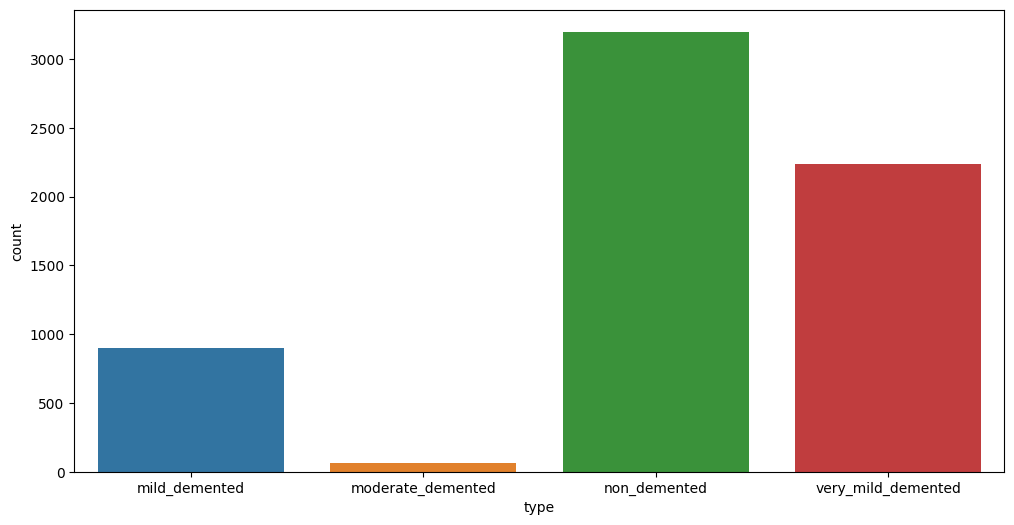

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x='type', ax=ax);

In [5]:
# remove moderate demented, not enough training examples
df = df[df.type != 'moderate_demented']

In [6]:
X, y = df.iloc[:,:-1], df['type']

In [7]:
sm = SMOTE(sampling_strategy='not majority', random_state=2, k_neighbors=10)
X_res, y_res = sm.fit_resample(X, y)

y_res = y_res.map({'non_demented': 1, 'very_mild_demented': 2, 'mild_demented': 3})

In [8]:
df_orig = df.copy()

df = pd.DataFrame(X_res.copy())
df['type'] = y_res

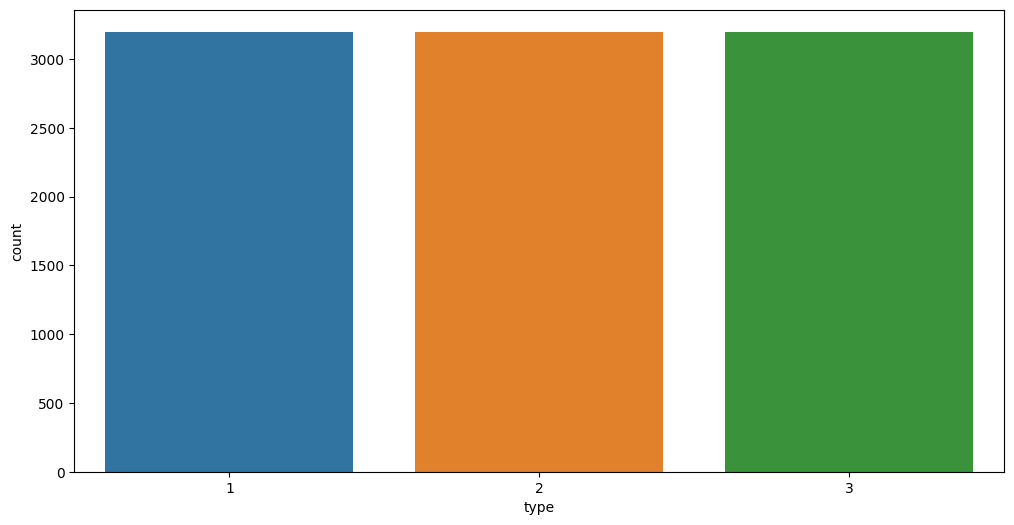

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x='type', ax=ax);

In [10]:
## remove 0 variance pixels
#df.var(numeric_only=True)

## Building a Neural Network

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

2023-04-26 18:20:21.939796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 18:20:22.408692: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-26 18:20:23.635367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/flemm0/miniconda3/envs/tf/lib/:/home/flemm0/miniconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-04-26 18:20:23.638094: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could

In [12]:
print(keras.__version__)

2.10.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.4, random_state=2)

X_train, X_test = X_train.astype('float32') / 255, X_test.astype('float32') / 255
y_train, y_test = np.array(y_train.astype('float32')), np.array(y_test.astype('float32'))

In [14]:
nn = Sequential()
nn.add(Dense(1000, input_shape=(16384,), activation='relu'))
nn.add(Dense(1000, activation='relu'))
nn.add(Dense(250, activation='softmax'))

2023-04-26 18:20:33.050155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 18:20:33.299214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 18:20:33.299285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 18:20:33.300953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

the code above is equivalent to passing list of dense layers into the `Sequential()` class:
```
nn = Sequential(
    [
        layers.Dense(1000, input_shape=(16384,), activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(250, activation='softmax')
    ]
)
```

In [15]:
nn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy', keras.metrics.SparseCategoricalAccuracy()])

In [16]:
nn.fit(X_train, y_train, epochs=70, batch_size=10)

Epoch 1/70
576/576 [==============================] - 7s 8ms/step - loss: 1.2576 - accuracy: 0.5208 - sparse_categorical_accuracy: 0.5208
Epoch 2/70
576/576 [==============================] - 4s 6ms/step - loss: 0.8128 - accuracy: 0.5811 - sparse_categorical_accuracy: 0.5811
Epoch 3/70
576/576 [==============================] - 3s 6ms/step - loss: 0.7810 - accuracy: 0.6092 - sparse_categorical_accuracy: 0.6092
Epoch 4/70
576/576 [==============================] - 3s 6ms/step - loss: 0.7660 - accuracy: 0.6085 - sparse_categorical_accuracy: 0.6085
Epoch 5/70
576/576 [==============================] - 3s 6ms/step - loss: 0.6945 - accuracy: 0.6519 - sparse_categorical_accuracy: 0.6519
Epoch 6/70
576/576 [==============================] - 3s 6ms/step - loss: 0.6393 - accuracy: 0.7016 - sparse_categorical_accuracy: 0.7016
Epoch 7/70
576/576 [==============================] - 3s 6ms/step - loss: 0.5815 - accuracy: 0.7333 - sparse_categorical_accuracy: 0.7333
Epoch 8/70
576/576 [==============

In [17]:
#_, accuracy = nn.evaluate(X_test, y_test)
#print('Accuracy: %.2f' % (accuracy*100))
results = nn.evaluate(X_test, y_test)
print("test loss: {}, test acc: {}".format(results[0], results[1]))

120/120 [==============================] - 1s 4ms/step - loss: 0.9490 - accuracy: 0.7974 - sparse_categorical_accuracy: 0.7974
test loss: 0.9489967823028564, test acc: 0.7973958253860474


120/120 [==============================] - 0s 3ms/step


Text(0.5, 47.5815972222222, 'Predicted label')

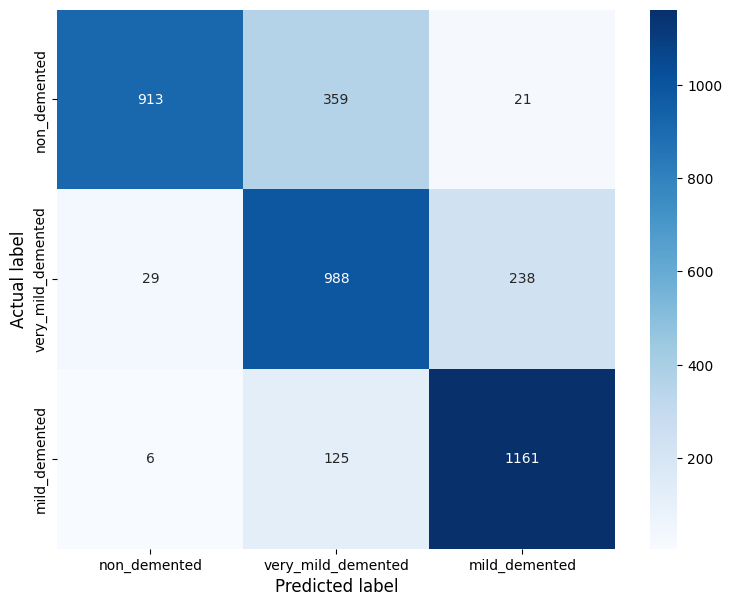

In [18]:
y_pred = nn.predict(X_test)

cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
labels = ['non_demented', 'very_mild_demented', 'mild_demented']

fig, ax = plt.subplots(figsize=(9,7))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
ax.set_ylabel('Actual label', fontsize=12)
ax.set_xlabel('Predicted label', fontsize=12)

The model predicts non demented and mild demented patients well, but confuses a good amount of very mild demented with mild demented

In [19]:
## code to verify which labels (0, 1, 2) correspond to the actual labels
pd.crosstab(y_test, y_pred.argmax(axis=1), rownames=['Actual'], colnames=['Predicted'], margins=False)

Predicted,1,2,3
Actual,,,
1.0,913,359,21
2.0,29,988,238
3.0,6,125,1161


## Using Convolutional Neural Network

In [20]:
# CNNs need different input shapes: (a, b, c, d) where:
# a = number of images
# (b, c) = shape/size of image (in pixels)
# d = number of channels (1 for grayscale, and 3 for colored/RGB images)


X_train, X_test = np.array(X_train).reshape(5760, 128, 128, 1), np.array(X_test).reshape(3840, 128, 128, 1)

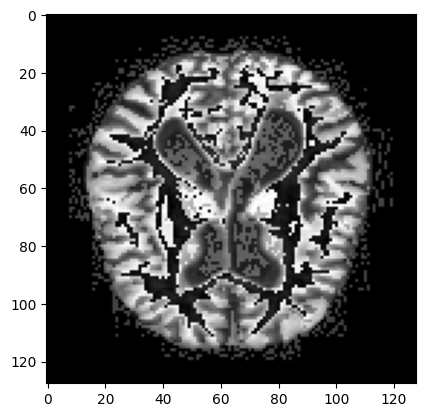

In [21]:
plt.imshow(X_train[0], cmap='gray');

In [22]:
cnn = Sequential(
    [
        Conv2D(50, kernel_size=15, input_shape=(128, 128, 1), activation='relu'),
        Conv2D(50, kernel_size=15, activation='relu'),
        Flatten(),
        Dense(10, activation='softmax')
    ]
)

cnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [23]:
cnn.fit(X_train, y_train, epochs=10, batch_size=10)

Epoch 1/10


2023-04-26 18:24:50.036103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900
2023-04-26 18:24:53.222055: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-04-26 18:24:53.436838: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-04-26 18:24:53.436896: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-26 18:24:53.645038: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-04-26 18:24:53.645213: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


576/576 [==============================] - 32s 35ms/step - loss: 0.9451 - sparse_categorical_accuracy: 0.5422
Epoch 2/10
576/576 [==============================] - 19s 32ms/step - loss: 0.8254 - sparse_categorical_accuracy: 0.5948
Epoch 3/10
576/576 [==============================] - 20s 35ms/step - loss: 0.7504 - sparse_categorical_accuracy: 0.6425
Epoch 4/10
576/576 [==============================] - 19s 33ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.7059
Epoch 5/10
576/576 [==============================] - 19s 34ms/step - loss: 0.5281 - sparse_categorical_accuracy: 0.7748
Epoch 6/10
576/576 [==============================] - 19s 34ms/step - loss: 0.3331 - sparse_categorical_accuracy: 0.8635
Epoch 7/10
576/576 [==============================] - 20s 35ms/step - loss: 0.1771 - sparse_categorical_accuracy: 0.9330
Epoch 8/10
576/576 [==============================] - 18s 32ms/step - loss: 0.0829 - sparse_categorical_accuracy: 0.9719
Epoch 9/10
576/576 [=======================

In [25]:
results = cnn.evaluate(X_test, y_test)
print("test loss: {}, test acc: {}".format(results[0], results[1]))

120/120 [==============================] - 5s 21ms/step - loss: 0.7586 - sparse_categorical_accuracy: 0.8404
test loss: 0.7586074471473694, test acc: 0.8403645753860474


120/120 [==============================] - 2s 19ms/step


Text(0.5, 47.5815972222222, 'Predicted label')

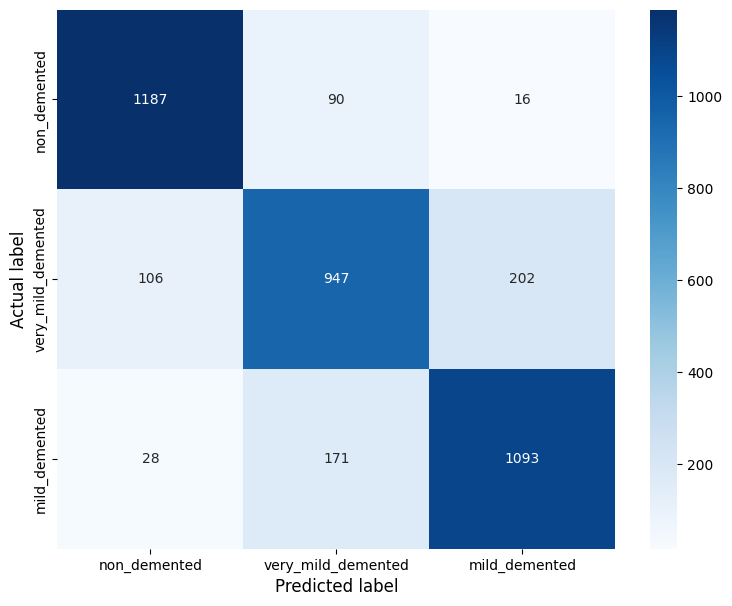

In [26]:
y_pred = cnn.predict(X_test)

cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
labels = ['non_demented', 'very_mild_demented', 'mild_demented']

fig, ax = plt.subplots(figsize=(9,7))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
ax.set_ylabel('Actual label', fontsize=12)
ax.set_xlabel('Predicted label', fontsize=12)